# Setups

In [1]:
# ==========================================
# 0. PASTE ROBOCLOW API CODE HERE
# Run this cell first to download and unzip the dataset.
# The data will be located in the /content/dataset/ folder structure.
# ==========================================

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="I2CQD19fHc1x2IlIFhEa")
project = rf.workspace("testing-jlqd8").project("robotics-obj-detection-y9er1")
version = project.version(4)
# CHANGED FROM "clip" TO "clip-classification"
dataset = version.download("clip")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 69.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Robotics-Obj-detection-4 in clip:: 100%|██████████| 4363/4363 [00:00<00:00, 11835.23it/s]


In [2]:
# ==========================================
# 1. IMPORTS AND SETUP
# ==========================================
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import os
import numpy as np

# Adjust based on the actual path the Roboflow snippet created
DATASET_PATH = dataset.location
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
NUM_CLASSES = 4 # 4 objects

# IMPORTANT: Ensure this order matches the labels Roboflow assigned (Check your Roboflow data.yaml)
# Based on the assignment, the class names are:

class_names = ["Book", "Newspaper", "Old school bag", "Zip-top can"]

In [3]:
# 1.5 Checking Directory of dataset
import os
import glob

# Use the path determined from your successful API download
# This should be '/content/Robotics-Obj-detection-4'
DATASET_BASE_PATH = dataset.location

# 1. Print the contents of the top level
print("Contents of Base Path:", os.listdir(DATASET_BASE_PATH))
# Expected output: ['train', 'valid', 'test', 'README.dataset.txt', 'data.yaml']

# 2. Print the contents of the 'train' folder
TRAIN_PATH = os.path.join(DATASET_BASE_PATH, 'train')
print("\nContents of TRAIN folder:", os.listdir(TRAIN_PATH))
# Expected output: ['Book', 'Newspaper', 'Zip-top Can', 'Old School Bag']
# If you see ONE wrapper folder name here (e.g., ['clip-images']), that's the problem!

# 3. Print the contents of one class folder (e.g., 'Book')
BOOK_PATH = glob.glob(os.path.join(TRAIN_PATH, 'Book'))[0]
print("\nContents of the 'Book' folder (first 5 files):", os.listdir(BOOK_PATH)[:5])
# Expected output: List of image file names (e.g., ['img_001.jpg', ...])

Contents of Base Path: ['README.roboflow.txt', 'valid', 'README.dataset.txt', 'train', 'test']

Contents of TRAIN folder: ['Old school bag', 'empty', 'Newspaper', 'Zip-top can', 'Book', '_tokenization.txt']

Contents of the 'Book' folder (first 5 files): ['frame_00072_jpg.rf.1dd4612cd69a6d64f476ca6c1d07835d.jpg', 'frame_00143_jpg.rf.b396fe9b82f4732b2b467a42f740ad84.jpg', 'frame_00042_jpg.rf.1c8e8a9346c19c8d5cc876ff40341f29.jpg', 'frame_00053_jpg.rf.db6273f4e45d33cda1d2a04052e17728.jpg', 'frame_00061_jpg.rf.948982bfa09b7daf08e9bbab35ddb3dc.jpg']


# Data Preparation

In [4]:
# ==========================================
# 2. DATASET LOADING (Keras Standard)
# ==========================================
def load_data(split):
    return tf.keras.utils.image_dataset_from_directory(
        os.path.join(DATASET_PATH, split),
        shuffle=True,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        # <-- FIX 1: Explicitly set label mode to 'int'
        label_mode='int',
        # ADD THIS LINE: Explicitly list the folders to include, excluding 'empty' and others.
        class_names=class_names
    )

train_ds = load_data('train')
val_ds = load_data('valid')

# Optimize data loading performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3852 files belonging to 4 classes.
Found 241 files belonging to 4 classes.


In [5]:
# 3. DATA AUGMENTATION & PREPROCESSING
# ==========================================
# Assignment Requirement: Normalize pixel values to [0,1]
preprocess_layer = layers.Rescaling(1./255)

# Assignment Requirement: Augment with rotation, brightness, horizontal flips
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomBrightness(0.2),
])

# Load MobileNetV2 (Pre-trained model) + Classification head

In [6]:
# ==========================================
# 4. MODEL ARCHITECTURE (MobileNetV2 Transfer Learning)
# ==========================================
# Load MobileNetV2 with ImageNet weights, exclude top
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model initially
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
# x = preprocess_layer(inputs) -> change to line above to try and fix model from having zero learning and having accuracy stuck at 0.25
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)

# Add Custom Head (Assignment Specific Layers)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Compile Phase 1 (Initial Learning Rate: 1e-3 suggested for initial head training)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("--- Model Summary (Initial Head) ---")
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
--- Model Summary (Initial Head) ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Training (Base + Fine tune)

In [7]:
# ==========================================
# 5. TRAINING PHASE 1 (Train Head Only)
# ==========================================
print("\n--- Phase 1: Training Head (10 Epochs) ---")
history_phase1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=4
)


--- Phase 1: Training Head (10 Epochs) ---
Epoch 1/4
121/121 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.4845 - loss: 1.2206 - val_accuracy: 0.8797 - val_loss: 0.4719
Epoch 2/4
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.8616 - loss: 0.4342 - val_accuracy: 0.8963 - val_loss: 0.3240
Epoch 3/4
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.9045 - loss: 0.3022 - val_accuracy: 0.9170 - val_loss: 0.2694
Epoch 4/4
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9178 - loss: 0.2437 - val_accuracy: 0.9170 - val_loss: 0.2565


In [8]:
# ==========================================
# 6. TRAINING PHASE 2 (Fine-Tuning Last 20-40 Layers)
# ==========================================
# Assignment Requirement: Fine-tune last 20-40 layers with smaller LR (1e-4)

# Unfreeze the base model
base_model.trainable = True

# Freeze all layers except the last 40 layers of the base model
fine_tune_at = len(base_model.layers) - 40
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with the required lower learning rate
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("\n--- Phase 2: Fine-Tuning (Additional 10 Epochs) ---")
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=12, # Total epochs: 10 + 10 = 20
    initial_epoch=history_phase1.epoch[-1]
)


--- Phase 2: Fine-Tuning (Additional 10 Epochs) ---
Epoch 4/12
121/121 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.8702 - loss: 0.3974 - val_accuracy: 0.9419 - val_loss: 0.2374
Epoch 5/12
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.9299 - loss: 0.2135 - val_accuracy: 0.9544 - val_loss: 0.2085
Epoch 6/12
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.9461 - loss: 0.1551 - val_accuracy: 0.9585 - val_loss: 0.2062
Epoch 7/12
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.9603 - loss: 0.1302 - val_accuracy: 0.9668 - val_loss: 0.2000
Epoch 8/12
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.9648 - loss: 0.1112 - val_accuracy: 0.9710 - val_loss: 0.1995
Epoch 9/12
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.9687 - loss: 0.0984 - val_accuracy: 0.9710 - val_loss: 0.1998
Epoch 10/12
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.9664 - loss: 0.0966 - val_accuracy: 0.9751 - val_loss: 0.1958
Epoch 11/12
121/121 ━━━━━━━━━━━━━━━━━━

# Testing + Result Validation (test result, confusion matrix)

In [9]:
# ==========================================
# 6.5A MODEL EVALUATION ON TEST DATA (Required Final Metric)
# ==========================================
import os
import tensorflow as tf

# Load the test dataset (This data was never seen by the model during training)
# NOTE: This uses the load_data function defined in Step 2.
try:
    print("\n--- Loading Test Dataset ---")
    test_ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(DATASET_PATH, 'test'),
        shuffle=False, # Do not shuffle the test set for consistent evaluation
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='int' # Ensure consistency with training setup
    )
    test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

    # Evaluate the model on the test data
    print("\n--- Evaluating Final Model on Test Data ---")
    loss, acc = model.evaluate(test_ds, verbose=2)

    print(f"\n✅ Final Test Accuracy: {acc*100:.2f}%")
    print(f"✅ Final Test Loss: {loss:.4f}")

except Exception as e:
    print(f"\n❌ ERROR during Test Evaluation: {e}")
    print("Ensure your Roboflow dataset includes a 'test' split and the path is correct.")


--- Loading Test Dataset ---
Found 241 files belonging to 4 classes.

--- Evaluating Final Model on Test Data ---
8/8 - 0s - 58ms/step - accuracy: 0.9751 - loss: 0.0831

✅ Final Test Accuracy: 97.51%
✅ Final Test Loss: 0.0831


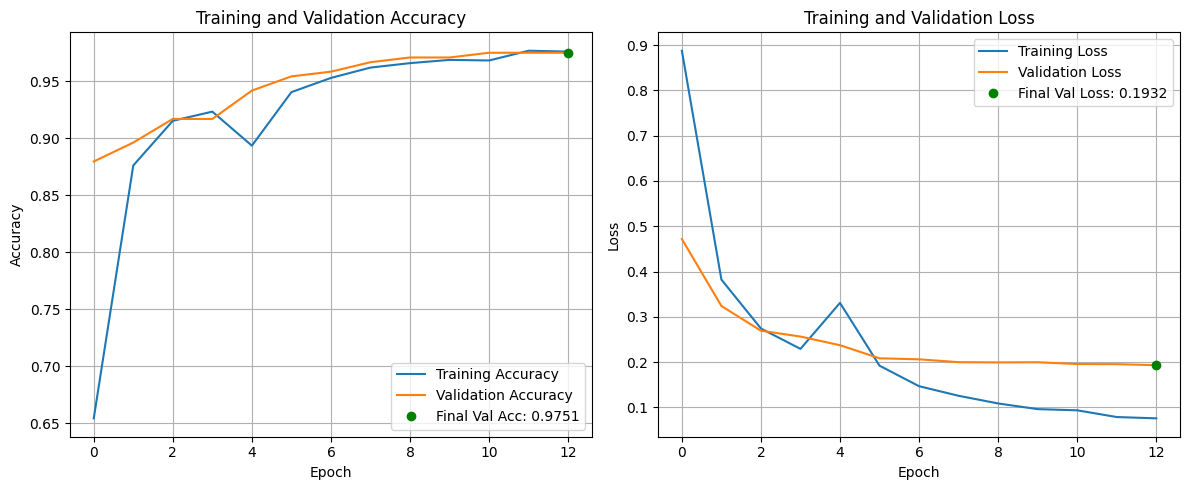

In [10]:
# ==========================================
# 6.5B ACCURACY AND LOSS VISUALIZATION (CORRECTED)
# ==========================================
import matplotlib.pyplot as plt

# 1. Combine the history from Phase 1 and Phase 2
# We access the lists directly from the history objects you created in Step 5 & 6
acc = history_phase1.history['accuracy'] + history_fine.history['accuracy']
val_acc = history_phase1.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history_phase1.history['loss'] + history_fine.history['loss']
val_loss = history_phase1.history['val_loss'] + history_fine.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# 2. Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# Highlight the final validation accuracy
plt.plot(len(acc)-1, val_acc[-1], 'go', label=f'Final Val Acc: {val_acc[-1]:.4f}')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

# 3. Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
# Highlight the final validation loss
plt.plot(len(loss)-1, val_loss[-1], 'go', label=f'Final Val Loss: {val_loss[-1]:.4f}')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Save model to use for evaluation & validation below (from 7A - 7D)

# Save Keras .h5 model (Deliverable 1)
# Change the extension from .h5 to .keras
model.save('robot_classifier.keras')
print("\nSaved Keras Model: robot_classifier.keras")


Saved Keras Model: robot_classifier.keras


In [14]:
# ==========================================
# 7A. GENERATE PREDICTIONS
# ==========================================

# 1. Load the trained model (Ensure this points to your final model save)
# Assuming you saved the final model as 'robot_classifier.keras'
model = tf.keras.models.load_model('robot_classifier.keras')

# 2. Extract true labels (y_true)
# NOTE: This assumes 'validation_dataset' is the TensorFlow Dataset used in training.
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

# 3. Generate predictions (y_pred_probs)
# Use verbose=1 to see the progress
y_pred_probs = model.predict(test_ds, verbose=1)

# 4. Convert probabilities to class indices (y_pred)
# argmax finds the index of the highest probability, which is the predicted class
y_pred = np.argmax(y_pred_probs, axis=1)

# Check results
print(f"Total True Labels: {len(y_true)}")
print(f"Total Predicted Labels: {len(y_pred)}")

# The class_names variable MUST match the order of labels detected in Step 2
# e.g., ["Book", "Newspaper", "Old school bag", "Zip-top can"]
# You should retrieve this from your class_names variable defined in Step 2.
NUM_CLASSES = len(class_names)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step
Total True Labels: 241
Total Predicted Labels: 241


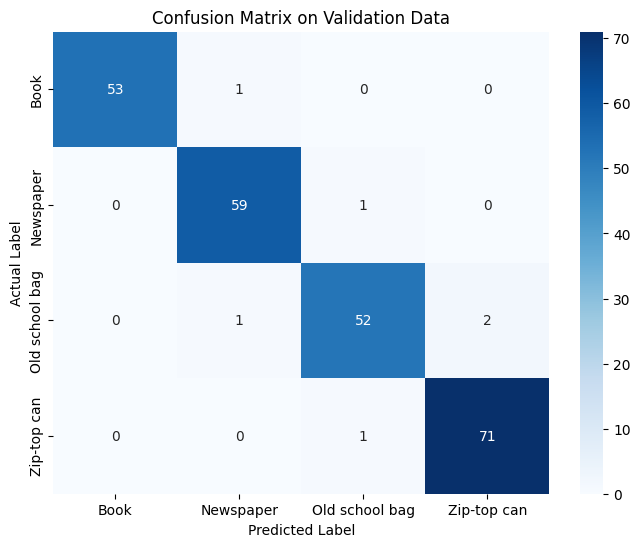

Saved confusion matrix as 'confusion_matrix.png'


In [15]:
# ==========================================
# 7B. CONFUSION MATRIX PLOT
# ==========================================

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title('Confusion Matrix on Validation Data')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.show()
print("Saved confusion matrix as 'confusion_matrix.png'")

In [16]:
# ==========================================
# 7C. CLASSIFICATION REPORT (Precision, Recall, F1-Score)
# ==========================================

print("\n--- CLASSIFICATION REPORT ---")
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# Optionally save the report to a text file
with open('classification_report.txt', 'w') as f:
    f.write(report)
print("Saved classification report as 'classification_report.txt'")


--- CLASSIFICATION REPORT ---
                precision    recall  f1-score   support

          Book       1.00      0.98      0.99        54
     Newspaper       0.97      0.98      0.98        60
Old school bag       0.96      0.95      0.95        55
   Zip-top can       0.97      0.99      0.98        72

      accuracy                           0.98       241
     macro avg       0.98      0.97      0.97       241
  weighted avg       0.98      0.98      0.98       241

Saved classification report as 'classification_report.txt'


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


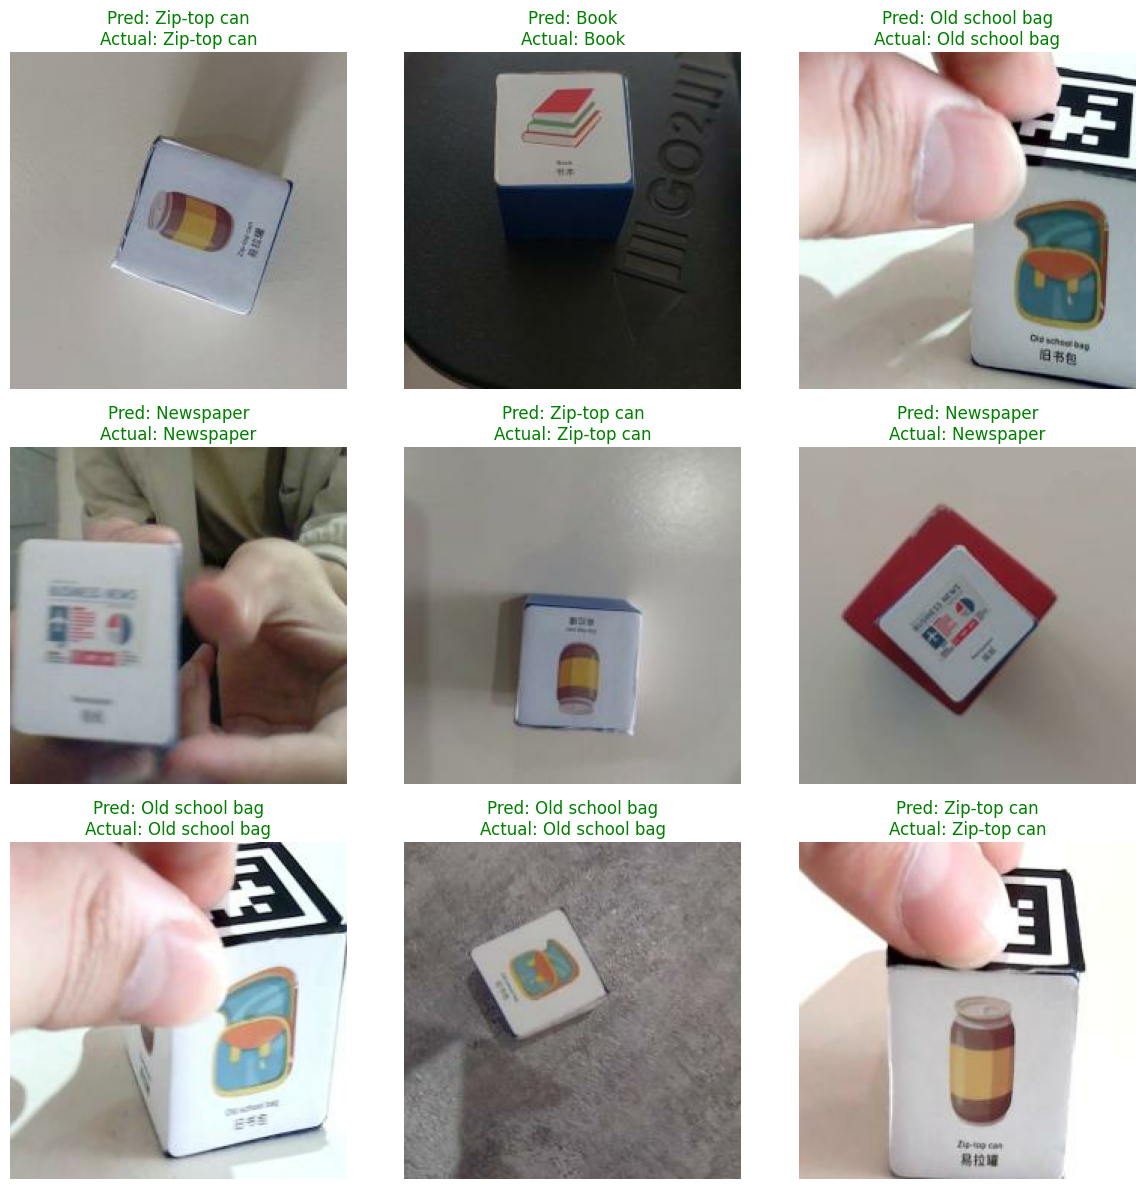

Saved qualitative prediction plot as 'qualitative_predictions.png'


In [17]:
# ==========================================
# 7D. QUALITATIVE PREDICTION EXAMPLES (FINAL CORRECTED)
# ==========================================
import matplotlib.pyplot as plt
import numpy as np
import random

# Mapping of numeric labels to class names (must match training order)
class_names = ['Book', 'Newspaper', 'Old school bag', 'Zip-top can']

# 1. Collect all test images and labels
# We assume test_ds yields images in [0, 255] (RGB) because no external scaling was applied.
all_images = []
all_labels = []

# Iterate over the dataset
for images, labels in test_ds:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# 2. Randomly select 9 images
indices = random.sample(range(len(all_images)), 9)
sample_images = all_images[indices]
sample_labels = [class_names[i] for i in all_labels[indices]]

# 3. Predict
# CRITICAL FIX: Pass the [0, 255] images DIRECTLY to the model.
# The model has an internal 'preprocess_input' layer that handles the scaling.
preds = model.predict(sample_images)
pred_classes = [class_names[np.argmax(p)] for p in preds]

# 4. Prepare for Display
# CRITICAL FIX: The images are already [0, 255] RGB. Just convert to uint8 integers.
# No rescaling calculations needed.
images_to_plot = sample_images.astype("uint8")

# 5. Plot 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(images_to_plot):
        ax.axis('off')
        continue

    # Plot the raw RGB image
    ax.imshow(images_to_plot[i])

    # Highlight prediction success/failure
    color = "green" if pred_classes[i] == sample_labels[i] else "red"
    ax.set_title(f"Pred: {pred_classes[i]}\nActual: {sample_labels[i]}", color=color)
    ax.axis('off')

plt.tight_layout()
plt.savefig('qualitative_predictions.png')
plt.show()
print("Saved qualitative prediction plot as 'qualitative_predictions.png'")

# Model Saving + Conversion

In [13]:
# ==========================================
# 7. MODEL SAVING AND CONVERSION (Deliverables)
# ==========================================

# Save Keras .h5 model (Deliverable 1)
# Change the extension from .h5 to .keras
model.save('robot_classifier.keras')
print("\nSaved Keras Model: robot_classifier.keras")

# TFLite Conversion with Float16 Quantization (Deliverable 2)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()

# Save the TFLite file
with open('robot_model_f16.tflite', 'wb') as f:
    f.write(tflite_model)

print("Successfully created TFLite Model: robot_model_f16.tflite (Float16)")


Saved Keras Model: robot_classifier.keras
Saved artifact at '/tmp/tmpy3rggy71'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  137068851863504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137068828661840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137068828662032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137068828659152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137068828659536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137068828661456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137068828662608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137068828663568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137068828663184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137068828662416: TensorSpec(shape=(),

# Validation of exported Model (.tflite file) (Can run on vscode, since running in colab uses gpu runtime -> very high fps which is inaccurate for raspberry pi deployment)

In [14]:
import tensorflow as tf
import numpy as np
import time

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="robot_model_f16.tflite")
interpreter.allocate_tensors()

# Get input and output details (used to know the required shape and type)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Example input shape (adjust this to your model's input)
input_shape = input_details[0]['shape']
# The input dtype will be the dtype of your TFLite model (e.g., float32 or float16)
input_dtype = input_details[0]['dtype']

    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    


In [15]:
# Create a dummy input array matching the model's required shape and dtype
# Use actual test data from your dataset for a real-world test!
dummy_input = np.random.rand(*input_shape).astype(input_dtype)

# Set the tensor for the interpreter
interpreter.set_tensor(input_details[0]['index'], dummy_input)

In [16]:
# --- Warm-up Run (Recommended) ---
interpreter.invoke()

# --- Benchmarking Runs ---
num_inferences = 100
total_time = 0

for i in range(num_inferences):
    start_time = time.time()

    # Set the input tensor for each run (in a real app, this is new frame data)
    interpreter.set_tensor(input_details[0]['index'], dummy_input)

    # Invoke the interpreter
    interpreter.invoke()

    end_time = time.time()
    total_time += (end_time - start_time)

# Calculate average inference time
avg_inference_time_ms = (total_time / num_inferences) * 1000

print(f"Total time for {num_inferences} inferences: {total_time:.4f} seconds")
print(f"Average inference time: {avg_inference_time_ms:.2f} milliseconds")
print(f"Inference Speed (FPS): {1000 / avg_inference_time_ms:.2f} FPS")

Total time for 100 inferences: 0.7278 seconds
Average inference time: 7.28 milliseconds
Inference Speed (FPS): 137.41 FPS


Validation of export model using LiteRT (Again, can run in vscode, colab uses gpu runtime -> high fps -> inaccurate measure for when testing on robot pi)

In [17]:
# Install the recommended LiteRT package
!pip install ai-edge-litert -q

# --- Imports ---
import time
import numpy as np
import os
from ai_edge_litert.interpreter import Interpreter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 MB 12.6 MB/s eta 0:00:00


In [19]:
# --- Configuration ---
# Use the file name of your uploaded model
MODEL_PATH = "robot_model_f16.tflite"
NUM_RUNS = 100 # Number of times to run inference for averaging

# 1. Load LiteRT model and setup
try:
    interpreter = Interpreter(model_path=MODEL_PATH)
    interpreter.allocate_tensors()

    # Get input/output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    input_shape = input_details[0]['shape']

    # 2. Generate dummy data matching the required input shape (e.g., [1, 224, 224, 3])
    # Note: The data type must match the model's expected type (usually float32)
    input_data = np.array(np.random.random_sample(input_shape), dtype=input_details[0]['dtype'])

    # 3. Warm-up runs (to ensure caches are hot before timing)
    print("Warming up LiteRT interpreter...")
    for _ in range(10):
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()

    print(f"Model loaded and ready for {NUM_RUNS} runs.")

except Exception as e:
    print(f"An error occurred during model loading and setup: {e}")

Warming up LiteRT interpreter...
Model loaded and ready for 100 runs.


In [20]:
# --- Benchmarking ---

print(f"Starting {NUM_RUNS} inference runs...")
times = []
try:
    for i in range(NUM_RUNS):
        start_time = time.perf_counter()

        # Set input tensor
        interpreter.set_tensor(input_details[0]['index'], input_data)

        # Run inference
        interpreter.invoke()

        # Get output tensor (completes the inference)
        _ = interpreter.get_tensor(output_details[0]['index'])

        end_time = time.perf_counter()
        times.append(end_time - start_time)

    # --- Calculate Metrics ---
    average_time_ms = np.mean(times) * 1000
    fps = 1 / np.mean(times)

    # --- Print Results ---
    print("\n🚀 LiteRT Benchmark Results 🚀")
    print("-" * 30)
    print(f"Average Inference Time (over {NUM_RUNS} runs): **{average_time_ms:.3f} ms**")
    print(f"Estimated Frames Per Second (FPS): **{fps:.2f}**")

except Exception as e:
    print(f"An error occurred during benchmarking: {e}")

Starting 100 inference runs...

🚀 LiteRT Benchmark Results 🚀
------------------------------
Average Inference Time (over 100 runs): **7.090 ms**
Estimated Frames Per Second (FPS): **141.04**


First Object-to-Action code

# Deployment code (The codes below, including pc testing code are all wrong, it was just a draft) -> check vscode for the updated and correct version

In [ ]:
# --- STEP 1: INSTALL NECESSARY LIBRARIES ON RASPBERRY PI --- -> on the terminal after SSH on robot
# sudo apt install python3-tflite-runtime
# pip3 install gpiozero opencv-python

from gpiozero import Robot
import tflite_runtime.interpreter as tflite
import numpy as np
import cv2
import time

In [ ]:
# --- STEP 2: ROBOT CONFIGURATION ---
# --- A. CONFIGURATION ---

# !!! CRITICAL: REPLACE THESE PINS with your actual motor driver connections !!!
# Example: Using BCM GPIO pins 17, 18 (Left) and 27, 22 (Right) for a dual H-bridge
# Check your L298N/motor HAT documentation for the correct pin mapping.
ROBOT = Robot(left=(17, 18), right=(27, 22))

TFLITE_MODEL_PATH = 'robot_model_f16.tflite'
# The order of these labels MUST EXACTLY match the alphanumeric order of your
# class folders used during training: Book, Newspaper, Old school bag, Zip-top can
LABELS = ["Book", "Newspaper", "Old school bag", "Zip-top can"]

IMG_SIZE = (224, 224) # MobileNetV2 input size
CONFIDENCE_THRESHOLD = 0.7
SPEED = 0.6 # Motor speed (0.0 to 1.0)

In [ ]:
# --- STEP 3: TENSORFLOW LITE INFERENCE AND ACTION LOGIC ---
# --- B. MOTOR CONTROL FUNCTIONS ---

def move_forward():
    ROBOT.forward(speed=SPEED)
    time.sleep(0.1)
def turn_left():
    ROBOT.left(speed=SPEED)
    time.sleep(0.1)
def turn_right():
    ROBOT.right(speed=SPEED)
    time.sleep(0.1)
def stop_robot():
    ROBOT.stop()
def reverse_robot():
    # As specified in the assignment: Stop / Reverse action
    ROBOT.backward(speed=SPEED)
    time.sleep(0.5) # Reverse for a brief moment
    ROBOT.stop()


def execute_robot_action(detected_object_label):
    """Maps the detected object to a robot movement."""

    if detected_object_label == "Zip-top can":
        print(">>> ACTION: Moving Forward (Target: Zip-top can)")
        move_forward()
    elif detected_object_label == "Book":
        print(">>> ACTION: Turning Left (Target: Book)")
        turn_left()
    elif detected_object_label == "Newspaper":
        print(">>> ACTION: Turning Right (Target: Newspaper)")
        turn_right()
    elif detected_object_label == "Old school bag":
        print(">>> ACTION: Stop / Reverse (Target: Old school bag)")
        reverse_robot()
    else:
        print(">>> ACTION: Unknown object. Stopping.")
        stop_robot()

In [ ]:
# --- STEP 4: MAIN REAL-TIME LOOP (SIMPLIFIED) ---
# --- C. TFLITE INFERENCE LOOP ---

def main_loop():
    # Load the TFLite model
    interpreter = tflite.Interpreter(model_path=TFLITE_MODEL_PATH)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Initialize Camera (0 usually refers to the built-in RPi camera or first USB cam)
    cap = cv2.VideoCapture(0)

    try:
        while True:
            # 1. Capture Frame
            ret, frame = cap.read()
            if not ret:
                print("Error: Cannot read frame from camera.")
                break

            # 2. Preprocessing: Resize and Scale to [-1, 1] for MobileNetV2
            input_data = cv2.resize(frame, IMG_SIZE)
            input_data = np.expand_dims(input_data, axis=0).astype(np.float32)
            # Scale from [0, 255] to [-1, 1] (f(x) = (x/127.5) - 1.0)
            input_data = (input_data / 127.5) - 1.0

            # 3. Run Inference
            interpreter.set_tensor(input_details[0]['index'], input_data)
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details[0]['index'])

            # 4. Post-processing
            prediction_index = np.argmax(output_data)
            confidence = output_data[0][prediction_index]
            detected_object = LABELS[prediction_index]

            print(f"Prediction: {detected_object} (Confidence: {confidence:.2f})")

            # 5. Execute Robot Action
            if confidence > CONFIDENCE_THRESHOLD:
                execute_robot_action(detected_object)
            else:
                stop_robot() # Stop if prediction is not confident enough

            # Display frame (optional, for debugging)
            # cv2.imshow('Robot Vision', frame)
            # if cv2.waitKey(1) & 0xFF == ord('q'): break

    except KeyboardInterrupt:
        print("Exiting loop.")
    finally:
        stop_robot()
        cap.release()
        # cv2.destroyAllWindows()

if __name__ == '__main__':
    main_loop()

# PC test camera code (for running .keras file in vscode)

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import time

# --- CONFIGURATION ---
KERAS_MODEL_PATH = 'robot_classifier.keras'  # Your saved file
LABELS = ["Book", "Newspaper", "Old school bag", "Zip-top can"]
IMG_SIZE = (224, 224)
CONFIDENCE_THRESHOLD = 0.7

# --- A. LOAD MODEL ---
try:
    print("Loading Keras Model...")
    model = tf.keras.models.load_model(KERAS_MODEL_PATH)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# --- B. CAMERA LOOP ---
def run_pc_test():
    # Use 0 for default webcam
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return

    try:
        while True:
            # 1. Capture Frame
            ret, frame = cap.read()
            if not ret: break

            # 2. Preprocessing (Must match MobileNetV2 preprocessing in the saved model)
            input_data = cv2.resize(frame, IMG_SIZE)
            # The saved Keras model expects a batch dimension and float data
            input_data = np.expand_dims(input_data, axis=0).astype(np.float32)

            # NOTE: Scaling to [-1, 1] is typically handled by the Lambda layer
            # you embedded in the Keras model architecture.

            # 3. Run Inference
            # The model predicts the output logits/probabilities
            predictions = model.predict(input_data, verbose=0)[0]

            # 4. Post-processing
            prediction_index = np.argmax(predictions)
            confidence = predictions[prediction_index]
            detected_object = LABELS[prediction_index]

            # 5. Display Result on Frame
            text = f"{detected_object}: {confidence*100:.2f}%"
            color = (0, 255, 0) if confidence > CONFIDENCE_THRESHOLD else (0, 0, 255)
            cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

            print(f"Prediction: {detected_object} (Confidence: {confidence:.2f})")

            # Display the resulting frame
            cv2.imshow('PC Model Test', frame)

            # Exit loop on 'q' press
            if cv2.waitKey(1) & 0xFF == ord('q'): break

    except Exception as e:
        print(f"An error occurred during the loop: {e}")
    finally:
        cap.release()
        cv2.destroyAllWindows()

if __name__ == '__main__':
    run_pc_test()